# Word to Vector in Product Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from itertools import combinations, groupby
from collections import Counter
from collections import OrderedDict
from IPython.display import display
from sklearn import datasets
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import gensim
from sklearn.decomposition import PCA

In [4]:
train_orders = pd.read_csv('order_products__train.csv')
prior_orders = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv').set_index('product_id')

## Turn the product ID to a string

### This is necessary because Gensim's Word2Vec expects sentences

In [5]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

### Extract the ordered products in each order

In [6]:
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [7]:
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
sentences = sentences.values

## Train Word2Vec model

In [8]:
model = gensim.models.Word2Vec(sentences, size=1000, window=longest, min_count=2, workers=6)

### Organize data for visualization

In [9]:
vocab = list(model.wv.vocab.keys())

In [10]:
print("Number of words:", len(vocab))

Number of words: 49583


### PCA transform the vectors into 2d

In [11]:
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

###  visualization

In [12]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=4)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(10, 10))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(10, 10),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

### Visualize a random sample

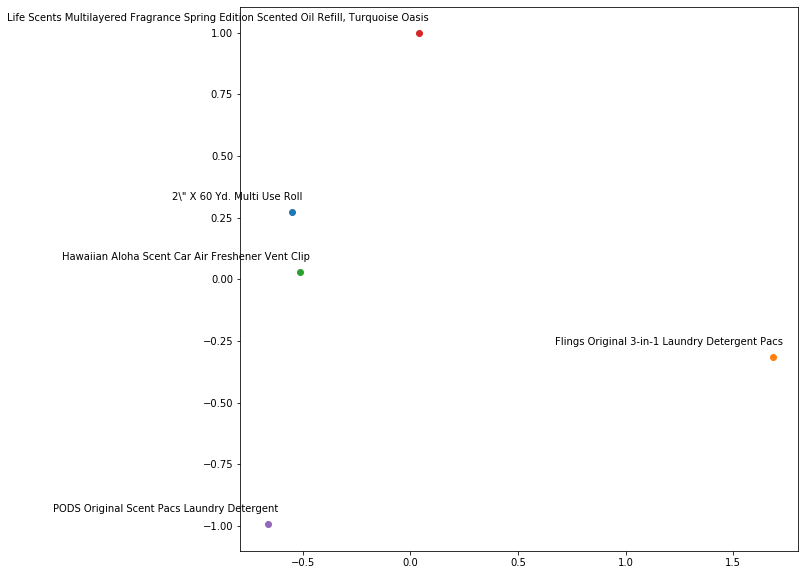

In [13]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=1):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

### Save the model

In [14]:
model.save("product2vec.model")